In [ ]:
#https://youtube.com/watch?v=qhRNvCVVJaA
#https://www.youtube.com/watch?v=mo96Nqlo1L8
#https://www.youtube.com/watch?v=HGeI30uATws
#https://www.datamachinist.com/reinforcement-learning/part-6-q-learning-for-continuous-state-problems/


In [ ]:

import gym 
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer


In [ ]:
class QLearnCartPoleSolver():
    def __init__(self, env, buckets=(6, 12), episodes=100, epsilon_decay_rate = 0.1, 
        decay=24, max_steps=100, batch_size = 64, min_lr=0.1, discount=1.0,min_epsilon=0.1):

        self.env = env
        self.action_size = self.env.action_space.n
        self.discount=discount
        self.buckets = buckets
        self.min_lr = min_lr
        self.min_epsilon = min_epsilon 
        self.episodes = episodes
        self.decay = decay
        self.epsilon_decay_rate = epsilon_decay_rate
        self.max_steps = max_steps
        self.batch_size = batch_size
        self.Q_Values = np.zeros(self.buckets +( self.action_size,))
        self.upper_bounds = [
            self.env.observation_space.high[2], math.radians(50)]
        self.lower_bounds = [
            self.env.observation_space.low[2], -math.radians(50)]


    def get_epsilon(self, t):
        return max(self.min_epsilon, min(1., 1. - math.log10((t + 1) / self.decay)))

    def get_learning_rate(self, t):
        return max(self.min_lr, min(1., 1. - math.log10((t + 1) / self.decay)))

    def action(self, state):
        return self.env.action_space.sample() if np.random.random() <= self.epsilon else np.argmax(self.Q_Values[state])

    def updated_q_value(self, state, action, reward, new_state):
        return (self.learning_rate * (reward + self.discount * np.max(self.Q_Values[new_state]) - self.Q_Values[state][action]))

    def discretize_state(self, state):
        _, _, angle, angle_velocity = state
        est = KBinsDiscretizer(n_bins=self.buckets,
                               encode='ordinal', strategy='uniform')
        est.fit([self.lower_bounds, self.upper_bounds])
        return tuple(map(int, est.transform([[angle, angle_velocity]])[0]))
    
    def train(self):
        scores = []
        for episode in range(self.episodes):
            self.learning_rate = self.get_learning_rate(episode)
            self.epsilon = self.get_epsilon(episode)
            state = self.discretize_state(self.env.reset())
            done = False
            reward_current_ep = 0
            while not done:
                # self.env.render()
                action = self.action(state)
                next_state, reward, done, _ = self.env.step(action) 
                next_state = self.discretize_state(next_state)
                self.Q_Values[state][action] += self.updated_q_value(state, action, reward, next_state)
                state = next_state
                reward_current_ep += 1
                # print(f"Trainingsession {episode+1}:", step, "steps")
            scores.append(reward_current_ep)
            print(f"{scores[episode]}  score for ep {episode+1}")
        print('Finished training!')
        #self.env.close()
        return scores
            
    def run(self):
        done = False
        current_state = self.discretize_state(self.env.reset())
        score = 0
        while not done:
            self.env.render()
            action = self.action(current_state)
            observation, reward, done, _ = self.env.step(action)
            new_state = self.discretize_state(observation)
            current_state = new_state
            score += reward
        print(f"score {score}")
        self.env.close()


In [ ]:

env = gym.make('CartPole-v0')
model = QLearnCartPoleSolver(env, episodes=5000)
scores = model.train()


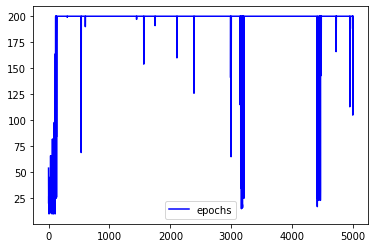

In [30]:
plt.plot(scores,  c='blue', label='epochs')
plt.legend()

In [ ]:
model.run()